In [2]:
# installing required packages and libraries
# !pip install torch torchvision pillow numpy pandas wandb matplotlib torchsummary kaggle scikit-learn
# !pip install torchsummary

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
import wandb
import os
import uuid
import gc
from tqdm import tqdm
import torch
from torch import optim
from torch.optim.lr_scheduler import CyclicLR
from torch.cuda.amp import GradScaler
 
from torch import nn
from torchsummary import summary
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

warnings.simplefilter('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"\nDevice: {device}\n")


Device: cuda



In [5]:
# downloading data from kaggle
# !kaggle competitions download -c dog-breed-identification
# !mv dog-breed-identification.zip data/

# !unzip -q data/dog-breed-identification.zip -d data/
# !rm -rf data/dog-breed-identification.zip

In [6]:
############## When running on kaggle ##############
# ROOT_DATA_DIR = '/kaggle/input/dog-breed-identification/'
# TEST_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'test')
# TRAIN_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'train')

# ############# When running on AWS #######################
ROOT_DATA_DIR = 'data'
TEST_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'test')
TRAIN_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'train')

In [7]:
# reading the csv labels
labels_df = pd.read_csv(os.path.join(ROOT_DATA_DIR, 'labels.csv'))

# extracting unique class names(breed)
labels = labels_df["breed"].unique().tolist()

# mapping breed with numerical value raning from 0 to 119(since we have 120 breed/classes)
labels_map = { value: index for index, value in enumerate(labels)}
labels_value_to_breed = { index: value for index, value in enumerate(labels)}

# adding a new column to labels dataframe by mapping breed column with 
# its corresponding numerical label
labels_df['label'] = labels_df['breed'].map(labels_map)

# extracting the numerical labels from labels dataframe
labels_num = labels_df['label'].tolist()

# encoding cardinal labels to 1 hot encoding. This is the final encoding to be used in the model
labels = np.eye(120)[labels_num]

In [8]:
def check_original_sample_with_different_dimensions(width, height):
    sample_image = Image.open(os.path.join(TRAIN_DATA_DIR, os.listdir(TRAIN_DATA_DIR)[np.random.randint(1000)]))
    return sample_image, sample_image.resize((width, width))

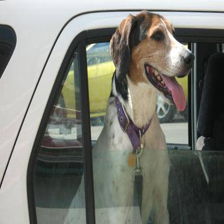

In [46]:
orginal, resized = check_original_sample_with_different_dimensions(224, 224
                                                                  )
# orginal.width, orginal.height
resized

In [47]:
class TrainDogBreedDataset(Dataset):
    """
        Dataset class for transforming images into tensors for training
    """
    def __init__(self, root_dir: str, partition: str, labels: np.ndarray, transform: list=[], training_data=True):
        """
            params:
                root_dir: is the root directory containing individual image names(not subdirectories)
                labels: numpy 2D array containing one-hot encoded image labels and ech 1D indice corresponds to 
                the indice or position of target image in the root directory
                transform: list of different transformation/data argumentations to be applied on the images
        """
        
        self.root_dir = root_dir
        self.transforms = transforms.Compose(transform)
        self.images = []  
        
        # reading images from the directory and convert them into PIL images
        image_filenames = os.listdir(self.root_dir)
        num_of_training_samples = int(0.8 * len(image_filenames))
        if training_data:
            image_filenames = image_filenames[: num_of_training_samples]
            self.labels = labels[: num_of_training_samples]
        else:
            image_filenames = image_filenames[num_of_training_samples: ]
            self.labels = labels[num_of_training_samples: ]
                
        for image_filename in image_filenames:
            image = Image.open(os.path.join(self.root_dir, image_filename))
            image = self.transforms(image)
            self.images.append(image)

        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    def denormalize(self, mean, std):
        denormalized_images = []
        denormalize_ = transforms.Normalize(mean=[-m / s for m, s in zip(mean, std)],std=[1 / s for s in std])
        for index, image in enumerate(self.images):
            denormalized_images.append(denormalize_(image))
        return denormalized_images

In [48]:
class TestDogBreedDataset(Dataset):
    """
        Dataset class for transforming images into tensors for testing
    """
    def __init__(self, root_dir: str, partition: str, transform:list=[]):
        """
            params:
                root_dir: is the root directory containing individual image names(not subdirectories)
                transform: list of different transformation/data argumentations to be applied on the images
        """
        self.root_dir = root_dir
        self.transforms = transforms.Compose(transform)
        self.images = []

        # reading images from the directory and convert them into PIL images
        image_filenames = os.listdir(self.root_dir)
        for image_filename in image_filenames:
            image = Image.open(os.path.join(self.root_dir, image_filename))
            image = self.transforms(image)
            self.images.append(image)

        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index]
    

In [49]:
def convert_tensor_image_to_pil_image(image_to_convert):
    pil_image_obj = transforms.ToPILImage()
    image_to_convert = torch.from_numpy(image_to_convert).to('cpu')
    return pil_image_obj(image_to_convert)

def plot_pil_images(images, labels_names, labels_numbers, figsize: tuple=None):
    if len(images) == 0:
        raise ValueError("Images cannot be empty")
    
    rows = int(np.sqrt(len(images)))
    cols = len(images) // rows
    
    if cols > rows:  #  I want rows to be greater than cols
        temp = rows
        rows = cols
        cols = temp
            
    fig, axes = plt.subplots(nrows=rows, ncols=cols)
    if figsize and len(images)!=1:
        fig.set_size_inches(figsize[0], figsize[1])
    
    if len(images) == 1:
            axes.imshow(convert_tensor_image_to_pil_image(images[0]))
            axes.axis('off')
            axes.set_title(labels_names[np.argmax(labels_numbers[0])])
    
    elif len(images) < 3:
        for i in range(len(images)):
            axes[i].imshow(convert_tensor_image_to_pil_image(images[i]))
            axes[i].axis('off')
            axes[i].set_title(labels_names[np.argmax(labels_numbers[i])])
    else:
        count_image = 0
        for row in range(rows):
            for col in range(cols):
                axes[row, col].imshow(convert_tensor_image_to_pil_image(images[count_image]))
                axes[row, col].axis('off')
                axes[row, col].set_title(labels_names[np.argmax(labels_numbers[count_image])])
                count_image += 1

    plt.show()

In [50]:
gc.collect()
transforms_args = [
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
train_dataset = TrainDogBreedDataset(root_dir=TRAIN_DATA_DIR, 
                                     partition="train",
                                    labels=labels,
                                    transform=transforms_args)

valid_dataset = TrainDogBreedDataset(root_dir=TRAIN_DATA_DIR, 
                                     partition="train",
                                    labels=labels,
                                    transform=transforms_args,
                                    training_data=False)

denormalized_valid_dataset = valid_dataset.denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# test_dataset = TestDogBreedDataset(root_dir=TEST_DATA_DIR, 
#                                      partition="test",
#                                      transform=[transforms.Resize((256, 256)),transforms.ToTensor()])

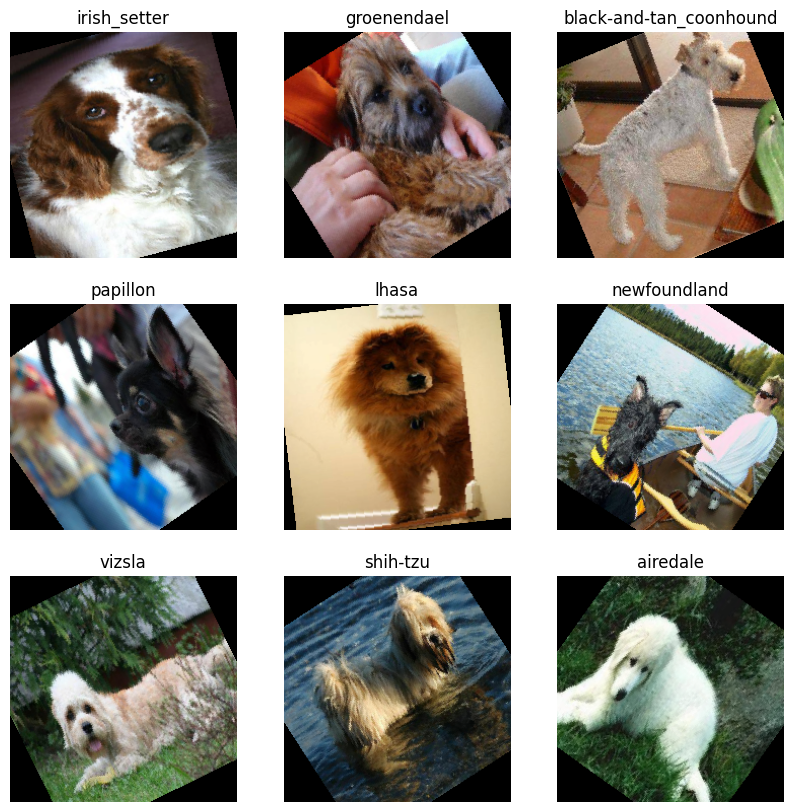

In [51]:
# valid sample
sample_images_indicies = np.random.randint(0, len(valid_dataset.images), size=(9,))
sample_images = np.array(denormalized_valid_dataset)[sample_images_indicies]
plot_pil_images(sample_images, 
                labels_names=labels_value_to_breed,
                labels_numbers=valid_dataset.labels,
                figsize=(10, 10))  # plotting sample images

In [52]:
valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=64,
                         shuffle=True,
                         num_workers=2)

In [166]:
# defining model architecture
class DogBreedNet(nn.Module):
    """
        Model architecture for dog breed identification and classification
        The model expects the images of size 400 x 400
    """
    def __init__(self, input_channels, num_classes, dense_dropout_p):
        """
            model instance construct
            params:
                input_channels: the number of channels for images(RGB -> 3 channels, grayscale -> one channel)
                num_classes: the number of classes for which images has to be classified into
                conv_dropout_p: the probability(percentage) of neurons to be dropped in the convolutional layers during training
                dense_dropout_p: the probability(percentage) of neurons to be dropped during in training in fully connected network(MLP)
        """
        super().__init__()
        self.block_1 = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=256, kernel_size=5, stride=3, padding=0),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.BatchNorm2d(256),
                                   
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=0),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  )
        
        
        self.block_2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=0),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  
                                  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512)
                                  )
        
        self.block_3 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2),
                                  nn.BatchNorm2d(512)
                                  )
        
        self.flatten_layer = nn.Flatten()
        
        self.mlp = nn.Sequential(nn.Linear(in_features = 512 * 8 * 8, out_features=1024),
                              nn.ReLU(),
                              nn.Dropout(dense_dropout_p),
                              
                              nn.Linear(in_features =1024, out_features=1024),
                              nn.ReLU(),
                              nn.Dropout(dense_dropout_p),
                               
                              nn.Linear(in_features = 1024, out_features=1024),
                              nn.ReLU(),
                               
                              nn.Linear(in_features = 1024, out_features=num_classes)
                              )
    
        self.softmax = nn.Softmax(dim=1)
    def forward(self, X):
        """
            params:
                X: batch of images to be passed into the model
                X has shape of (batch_size, num_channels, height, width)
        """
        out = self.block_1(X)
        out = self.block_2(out)
        out = self.block_3(out)
        out = self.flatten_layer(out)  # passing output of cnn layers to flatten layer
        out = self.mlp(out) # passing output of flatten layer to fully connected network
        out = self.softmax(out) # passing out of fully connected network to softmax for final logits
        
        return out

In [54]:
# Testing dataloaders
for X, y in valid_loader:
    break
X.shape

torch.Size([64, 3, 224, 224])

In [167]:
gc.collect()
X, y = X.to(device), y.to(device)
model = DogBreedNet(input_channels=3, num_classes=120, dense_dropout_p=.6).to(device)
summary(model, input_size=X.shape[1:], batch_size=64)
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 256, 74, 74]          19,456
              ReLU-2          [64, 256, 74, 74]               0
         MaxPool2d-3          [64, 256, 37, 37]               0
       BatchNorm2d-4          [64, 256, 37, 37]             512
            Conv2d-5          [64, 256, 18, 18]         590,080
              ReLU-6          [64, 256, 18, 18]               0
       BatchNorm2d-7          [64, 256, 18, 18]             512
            Conv2d-8          [64, 512, 16, 16]       1,180,160
              ReLU-9          [64, 512, 16, 16]               0
      BatchNorm2d-10          [64, 512, 16, 16]           1,024
           Conv2d-11          [64, 512, 16, 16]       2,359,808
             ReLU-12          [64, 512, 16, 16]               0
      BatchNorm2d-13          [64, 512, 16, 16]           1,024
           Conv2d-14          [64, 512,

In [158]:
config ={
    "batch_size": 64,
    "epochs": 50,
    "base_lr": 0.001,
    "max_lr": 0.1,
    "weight_decay": 4e-5
}

In [168]:
# Defining Data loaders to be used for training and testing
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=config["batch_size"],
                         shuffle=True,
                         num_workers=2,
                         pin_memory=True)

valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=config["batch_size"],
                         shuffle=True,
                         num_workers=2,
                         pin_memory=True)

# test_loader = DataLoader(dataset=test_dataset,
#                          batch_size=conifg["batch_size"],
#                          shuffle=False,
#                          num_workers=2)

In [169]:
def save_model_checkpoint(model, optimizer, epoch, val_acc, path, scheduler=None):
    """
     function for saving the model, and optimizer states and the epoch
     :param model: the model to save
     :param optimizer: the optimizer to save
     :param epoch: the epoch at which we save model state
     :param val_acc: validation accuracy at which the model is being saved
     :param path: the path on the drive where to save the checkpoint
    """
    data = {}
    data["model_state"] = model.to('cpu').state_dict()
    data["optimizer_state"] = optimizer.state_dict()
    data["epoch"] = epoch
    data["val_acc"] = val_acc
    if scheduler is not None:
        data["scheduler_state"] = scheduler.state_dict()
        
    torch.save(data, path)

def load_model_checkpoint(model, optimizer, path, scheduler=None):
    """
     function for loading the checkpoint for model state and optimizer
     :param model: the model to load state to
     :param optimzier: the optimizer to load state to
     :param path: the path in the drive where to load checkpoint from
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    epoch = checkpoint["epoch"]
    val_acc = checkpoint["val_acc"]
    
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint["scheduler_state"])
        return model, optimizer, epoch, scheduler
    return model, optimizer, epoch, val_acc

In [170]:
def calculate_loss(logits, true_labels):
    """
     function for calculating the loss between predicted labels and true labels
     the function uses cross entropy loss creterio
     :param lagits: are the predictions from the model
     :param true_labels: are the expected label
     
     return: calculated loss
    """
    loss = nn.CrossEntropyLoss()
    return loss(logits, true_labels)


def calculate_accuracy(logits, true_labels):
    """
     function for calculating the accuracy for each batch
     :param lagits: are the predictions from the model
     :param true_labels: are the expected label
    """
    predicted_classes = logits.argmax(dim=1)
    true_classes = true_labels.argmax(dim=1)
    correct_predictions = (predicted_classes == true_classes).sum().item()
    
    return correct_predictions

In [171]:
def training(model, optimizer, train_data_loader, scaler):
    """
     function for training the model
     :param model: the model to be trained
     :param optimizer: optimization algorithm to use for updating the model parameters
     :param train_data_loader: the loader containing data to be used during training
     :param sclaler: float precision alogrithm
    """
    model = model.to(device)
    model.train()  # putting model in the training mode
    num_correct = 0
    training_loss = 0
    
    # progress bar for batch
    batch_bar = tqdm(total=len(train_data_loader), dynamic_ncols=True, leave=False, position=0, ncols=5, 
                     desc="Train", unit=" images")
    for index, (images, true_labels) in enumerate(train_data_loader):
        images, true_labels = images.to(device, non_blocking=True), true_labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(images)
            loss = calculate_loss(logits, true_labels)
       
        training_loss += float(loss.item())
        num_correct += int(calculate_accuracy(logits, true_labels))
        
        batch_bar.set_postfix(
            accuracy=f"{(100*num_correct) / (config['batch_size'] * (index + 1)):.4f}%",
            num_correct=num_correct,
            loss=f"{training_loss / (index + 1):.4f}",
            learning_rate=f"{optimizer.param_groups[0]['lr']}"
        )
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        batch_bar.update()
    batch_bar.close()
    acc = (100 * num_correct) / (len(train_data_loader) * config['batch_size'])
    training_loss = training_loss / len(train_data_loader) 
    
    return acc, training_loss 

In [172]:
def validating(model, valid_data_loader):
    """
     function for training the model
     :param model: the model to be validated
     :param valid_data_loader: the loader containing data to be used during validation
    """
    model = model.to(device, non_blocking=True)
    model.eval() # putting the model into evaluation mode
    validation_loss, num_correct = 0, 0
    batch_bar = tqdm(total=len(valid_data_loader), desc="Valid", position=0, dynamic_ncols=True, 
                     ncols=7, leave=False, unit=' images')
    for index, (images, true_labels) in enumerate(valid_data_loader):
        images, true_labels = images.to(device, non_blocking=True), true_labels.to(device)
        with torch.inference_mode():
            logits = model(images)
            loss = loss = calculate_loss(logits, true_labels)
        
        validation_loss += float(loss.item())
        num_correct += int(calculate_accuracy(logits, true_labels))
        batch_bar.set_postfix(
            accuracy=f"{(100 * num_correct) / (config['batch_size'] * (index + 1)):.4f}%",
            num_correct=num_correct,
            loss= f"{validation_loss / (index + 1):.4f}"
        )
        
        batch_bar.update()
    batch_bar.close()
    valid_acc = (100 * num_correct) / (config['batch_size'] * len(valid_data_loader))
    validation_loss =  validation_loss / len(valid_data_loader)
    
    return valid_acc, validation_loss 

In [173]:
def test_model(model, test_data_loader):
    """
     function for training the model
     :param model: the model to be tested
     :param test_data_loader: the loader containing data to be used during testing 
    """
    model = model.to(device, non_blocking=True)
    model.eval()
    test_results = []
    
    batch_bar = tqdm(total=len(test_data_loader), position=0, desc="Test", dynamic_ncols=True, leave=False, ncols=7)
    for images in test_data_loader:
        images = model(images, non_blocking=True)
        with torch.inference_mode():
            logits = model(images)
        num_correct = logits.argmax(dim=1).detach().cpu().numpy().tolist()
        test_results.extend(num_correct)
        batch_bar.update()
    batch_bar.close()
    
    return test_results

In [174]:
# model experimentation
# 1. defining optimizer
# 2. defining shedulers
# 3. defining scaler
# 4. configuring wandb
# 5. writing training loops
# 6. defining model checkpoint path

gc.collect()
torch.cuda.empty_cache()
# Defining optimizer
optimizer = optim.Adam(params=model.parameters(), lr=config['base_lr'], weight_decay=config['weight_decay'])

# Defining scheduler
scheduler = CyclicLR(optimizer, base_lr=config['base_lr'], max_lr=config['max_lr'], step_size_up=20, 
                     mode='triangular', cycle_momentum=False)

# Defining scaler
scaler = GradScaler()

# Configuring WANDB
wandb.login(key="ef53fdb4276efbe5277b8c1a191ef4c4c133d7dd")
WANDB_NOTEBOOK_NAME = "dog_breed_identification"
run = wandb.init(
    name='dog-breed-ID',
    reinit=True,
    project=f'New-Ablations-{uuid.uuid4()}',
    config=config
)

# defining path where the model check point will be saved
# model_checkpoint_path = os.path.join(ROOT_DATA_DIR, "dog_breed_id_checkpoint.pth") # running on kaggle
model_checkpoint_path = os.path.join('checkpoints', "dog_breed_id_checkpoint.pth") # running on AWS

# implementing training loop for experimentations
best_validation_accuracy = 0.0
for epoch in range(1, config['epochs'] + 1, 1):
    current_lr = optimizer.param_groups[0]['lr']
    train_accuracy, train_loss = training(model=model, optimizer=optimizer, train_data_loader=train_loader, scaler=scaler)
    
    print(f"Epoch {epoch}/{config['epochs']}:\nTrain Acc: {train_accuracy:.4f}%\t Training Loss: {train_loss:.4f}\t Learning Rate: {current_lr:.4f}\n")
    
    validation_accuracy, validation_loss = validating(model=model, valid_data_loader=valid_loader)
    
    print(f"Validation Acc: {validation_accuracy:.4f}%\t Validation Loss: {validation_loss:.4f}\t Learning Rate: {current_lr:.4f}\n")
                                     
    wandb.log({
        "Train Loss": train_loss,
        "Train Accuracy": train_accuracy,
        "Validation Loss": validation_loss,
        "Validation Accuracy": validation_accuracy,
        "Learning Rate": current_lr
    })
    
    if validation_accuracy >  best_validation_accuracy:
        save_model_checkpoint(model=model, optimizer=optimizer, epoch=epoch, val_acc=validation_accuracy, path=model_checkpoint_path, scheduler=scheduler)
        best_validation_accuracy = validation_accuracy
        
#         saving checkpoint in wandb
        wandb.save('dog_breed_id_checkpoint.pth')

run.finish()   

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/50:
Train Acc: 0.8789%	 Training Loss: 4.7925	 Learning Rate: 0.0010



Validation Acc: 1.1719%	 Validation Loss: 4.7900	 Learning Rate: 0.0010



Epoch 2/50:
Train Acc: 1.0010%	 Training Loss: 4.7916	 Learning Rate: 0.0010



Validation Acc: 0.6836%	 Validation Loss: 4.7921	 Learning Rate: 0.0010



Epoch 3/50:
Train Acc: 0.7812%	 Training Loss: 4.7936	 Learning Rate: 0.0010



Validation Acc: 0.9766%	 Validation Loss: 4.7919	 Learning Rate: 0.0010



Epoch 4/50:
Train Acc: 0.9277%	 Training Loss: 4.7924	 Learning Rate: 0.0010



Validation Acc: 0.9766%	 Validation Loss: 4.7919	 Learning Rate: 0.0010



Epoch 5/50:
Train Acc: 0.8545%	 Training Loss: 4.7931	 Learning Rate: 0.0010



Validation Acc: 0.9766%	 Validation Loss: 4.7919	 Learning Rate: 0.0010



Epoch 6/50:
Train Acc: 0.8545%	 Training Loss: 4.7931	 Learning Rate: 0.0010



Validation Acc: 0.9766%	 Validation Loss: 4.7919	 Learning Rate: 0.0010



Epoch 7/50:
Train Acc: 0.8545%	 Training Loss: 4.7932	 Learning Rate: 0.0010



Validation Acc: 0.9766%	 Validation Loss: 4.7919	 Learning Rate: 0.0010



Epoch 8/50:
Train Acc: 0.8179%	 Training Loss: 4.7928	 Learning Rate: 0.0010



Validation Acc: 0.6836%	 Validation Loss: 4.7927	 Learning Rate: 0.0010



Epoch 9/50:
Train Acc: 0.7935%	 Training Loss: 4.7923	 Learning Rate: 0.0010



Validation Acc: 0.9766%	 Validation Loss: 4.7919	 Learning Rate: 0.0010



Epoch 10/50:
Train Acc: 0.8667%	 Training Loss: 4.7924	 Learning Rate: 0.0010



Validation Acc: 0.6348%	 Validation Loss: 4.7954	 Learning Rate: 0.0010



Epoch 11/50:
Train Acc: 1.1963%	 Training Loss: 4.7897	 Learning Rate: 0.0010



Validation Acc: 0.6348%	 Validation Loss: 4.7953	 Learning Rate: 0.0010



Epoch 12/50:
Train Acc: 1.0254%	 Training Loss: 4.7908	 Learning Rate: 0.0010



Validation Acc: 0.6348%	 Validation Loss: 4.7954	 Learning Rate: 0.0010



Epoch 13/50:
Train Acc: 1.1963%	 Training Loss: 4.7898	 Learning Rate: 0.0010



Validation Acc: 0.6348%	 Validation Loss: 4.7952	 Learning Rate: 0.0010



Epoch 14/50:
Train Acc: 1.1841%	 Training Loss: 4.7898	 Learning Rate: 0.0010



Validation Acc: 0.6348%	 Validation Loss: 4.7954	 Learning Rate: 0.0010



Epoch 15/50:
Train Acc: 1.2085%	 Training Loss: 4.7892	 Learning Rate: 0.0010



Validation Acc: 0.8301%	 Validation Loss: 4.7924	 Learning Rate: 0.0010



Epoch 16/50:
Train Acc: 1.0986%	 Training Loss: 4.7906	 Learning Rate: 0.0010



Validation Acc: 1.0742%	 Validation Loss: 4.7910	 Learning Rate: 0.0010



Epoch 17/50:
Train Acc: 1.0132%	 Training Loss: 4.7914	 Learning Rate: 0.0010



Validation Acc: 0.9277%	 Validation Loss: 4.7924	 Learning Rate: 0.0010



Epoch 18/50:
Train Acc: 1.0620%	 Training Loss: 4.7911	 Learning Rate: 0.0010



Validation Acc: 0.9277%	 Validation Loss: 4.7924	 Learning Rate: 0.0010



Epoch 19/50:
Train Acc: 1.0620%	 Training Loss: 4.7911	 Learning Rate: 0.0010



Validation Acc: 0.9277%	 Validation Loss: 4.7924	 Learning Rate: 0.0010



Epoch 20/50:
Train Acc: 1.0620%	 Training Loss: 4.7911	 Learning Rate: 0.0010



Validation Acc: 0.9277%	 Validation Loss: 4.7924	 Learning Rate: 0.0010



Epoch 21/50:
Train Acc: 1.0620%	 Training Loss: 4.7910	 Learning Rate: 0.0010



Validation Acc: 0.9277%	 Validation Loss: 4.7925	 Learning Rate: 0.0010



Epoch 22/50:
Train Acc: 1.2207%	 Training Loss: 4.7886	 Learning Rate: 0.0010



Validation Acc: 1.1719%	 Validation Loss: 4.7900	 Learning Rate: 0.0010



Epoch 23/50:
Train Acc: 1.0376%	 Training Loss: 4.7913	 Learning Rate: 0.0010



Validation Acc: 1.1719%	 Validation Loss: 4.7900	 Learning Rate: 0.0010



Epoch 24/50:
Train Acc: 0.9888%	 Training Loss: 4.7909	 Learning Rate: 0.0010



Validation Acc: 1.0742%	 Validation Loss: 4.7910	 Learning Rate: 0.0010



Epoch 25/50:
Train Acc: 0.9521%	 Training Loss: 4.7921	 Learning Rate: 0.0010



Validation Acc: 0.6348%	 Validation Loss: 4.7954	 Learning Rate: 0.0010



Epoch 26/50:
Train Acc: 0.7935%	 Training Loss: 4.7938	 Learning Rate: 0.0010



Validation Acc: 0.6348%	 Validation Loss: 4.7953	 Learning Rate: 0.0010



Epoch 27/50:
Train Acc: 0.9766%	 Training Loss: 4.7915	 Learning Rate: 0.0010



Validation Acc: 1.1719%	 Validation Loss: 4.7899	 Learning Rate: 0.0010



Epoch 28/50:
Train Acc: 1.0376%	 Training Loss: 4.7913	 Learning Rate: 0.0010



Validation Acc: 1.1230%	 Validation Loss: 4.7902	 Learning Rate: 0.0010



Epoch 29/50:
Train Acc: 1.0132%	 Training Loss: 4.7914	 Learning Rate: 0.0010



Validation Acc: 1.0742%	 Validation Loss: 4.7910	 Learning Rate: 0.0010



Epoch 30/50:
Train Acc: 0.8545%	 Training Loss: 4.7893	 Learning Rate: 0.0010



Validation Acc: 0.7324%	 Validation Loss: 4.7886	 Learning Rate: 0.0010



Epoch 31/50:
Train Acc: 0.7935%	 Training Loss: 4.7888	 Learning Rate: 0.0010



Validation Acc: 1.3184%	 Validation Loss: 4.7860	 Learning Rate: 0.0010



Epoch 32/50:
Train Acc: 1.0742%	 Training Loss: 4.7900	 Learning Rate: 0.0010



Validation Acc: 0.8789%	 Validation Loss: 4.7920	 Learning Rate: 0.0010



Epoch 33/50:
Train Acc: 1.1108%	 Training Loss: 4.7906	 Learning Rate: 0.0010



Validation Acc: 1.0742%	 Validation Loss: 4.7909	 Learning Rate: 0.0010



Epoch 34/50:
Train Acc: 1.1475%	 Training Loss: 4.7902	 Learning Rate: 0.0010



Validation Acc: 1.0742%	 Validation Loss: 4.7909	 Learning Rate: 0.0010



Epoch 35/50:
Train Acc: 1.1475%	 Training Loss: 4.7903	 Learning Rate: 0.0010



Validation Acc: 1.0742%	 Validation Loss: 4.7909	 Learning Rate: 0.0010



Epoch 36/50:
Train Acc: 1.1353%	 Training Loss: 4.7902	 Learning Rate: 0.0010



Validation Acc: 1.0742%	 Validation Loss: 4.7869	 Learning Rate: 0.0010



Epoch 37/50:
Train Acc: 1.0376%	 Training Loss: 4.7906	 Learning Rate: 0.0010



Validation Acc: 0.7812%	 Validation Loss: 4.7939	 Learning Rate: 0.0010



Epoch 38/50:
Train Acc: 0.9644%	 Training Loss: 4.7920	 Learning Rate: 0.0010



Validation Acc: 0.7812%	 Validation Loss: 4.7939	 Learning Rate: 0.0010



Epoch 39/50:
Train Acc: 0.9766%	 Training Loss: 4.7920	 Learning Rate: 0.0010



Validation Acc: 0.7324%	 Validation Loss: 4.7938	 Learning Rate: 0.0010



Epoch 40/50:
Train Acc: 0.9888%	 Training Loss: 4.7915	 Learning Rate: 0.0010



Validation Acc: 0.8301%	 Validation Loss: 4.7933	 Learning Rate: 0.0010



Epoch 41/50:
Train Acc: 0.9277%	 Training Loss: 4.7925	 Learning Rate: 0.0010



Validation Acc: 0.7812%	 Validation Loss: 4.7938	 Learning Rate: 0.0010



Epoch 42/50:
Train Acc: 0.9644%	 Training Loss: 4.7920	 Learning Rate: 0.0010



Validation Acc: 0.7812%	 Validation Loss: 4.7939	 Learning Rate: 0.0010



Epoch 43/50:
Train Acc: 0.9766%	 Training Loss: 4.7919	 Learning Rate: 0.0010



Validation Acc: 0.7812%	 Validation Loss: 4.7939	 Learning Rate: 0.0010



Epoch 44/50:
Train Acc: 0.9277%	 Training Loss: 4.7921	 Learning Rate: 0.0010



Validation Acc: 0.7812%	 Validation Loss: 4.7939	 Learning Rate: 0.0010



Epoch 45/50:
Train Acc: 0.9644%	 Training Loss: 4.7921	 Learning Rate: 0.0010



Validation Acc: 0.7812%	 Validation Loss: 4.7939	 Learning Rate: 0.0010



Epoch 46/50:
Train Acc: 0.9766%	 Training Loss: 4.7920	 Learning Rate: 0.0010



Validation Acc: 0.7812%	 Validation Loss: 4.7921	 Learning Rate: 0.0010



Epoch 47/50:
Train Acc: 0.9766%	 Training Loss: 4.7897	 Learning Rate: 0.0010



Validation Acc: 1.0742%	 Validation Loss: 4.7902	 Learning Rate: 0.0010



Epoch 48/50:
Train Acc: 0.9766%	 Training Loss: 4.7918	 Learning Rate: 0.0010



Validation Acc: 0.9277%	 Validation Loss: 4.7924	 Learning Rate: 0.0010



Epoch 49/50:
Train Acc: 1.0742%	 Training Loss: 4.7906	 Learning Rate: 0.0010



Validation Acc: 0.8301%	 Validation Loss: 4.7895	 Learning Rate: 0.0010



Epoch 50/50:
Train Acc: 0.9399%	 Training Loss: 4.7910	 Learning Rate: 0.0010



Validation Acc: 0.8789%	 Validation Loss: 4.7918	 Learning Rate: 0.0010



Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▃▅▁▃▂▂▂▁█▅█▇▆▅▅▅▅█▅▄▁▄▅▅▁▆▆▇▇▅▄▄▃▄▄▃▄▄▄▄
Train Loss,▆▅█▆▇▇▇▆▃▄▃▃▄▅▄▄▄▁▅▄█▅▅▅▁▃▄▃▃▄▆▆▆▆▆▆▆▂▅▄
Validation Accuracy,▇▁▅▅▅▅▁▅▁▁▁▁▅▄▄▄▄▇▇▅▁▇▆▅█▃▅▅▅▃▃▂▃▃▃▃▃▅▄▃
Validation Loss,▄▆▅▅▅▅▆▅████▅▆▆▆▆▄▄▅█▄▄▅▁▅▅▅▂▇▇▇▇▇▇▇▆▄▆▅
Learning Rate,0.001
Train Accuracy,0.93994
Train Loss,4.79099
Validation Accuracy,0.87891
Validation Loss,4.79179
